In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [62]:
evaluate_last_X_years = True
X=7
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [63]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [64]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2016-12-31,12137,-9416,2721,1827,1503,2017,10077,15016,0,...,53877,4239,0,1907,9646,8187,24491,2821,-1270,273
1,2017-03-31,12730,-10208,2522,1669,930,2652,9843,14598,0,...,53282,3968,0,1137,8315,7318,22263,1991,-1093,273
2,2017-06-30,11554,-9259,2295,1461,1706,2142,9159,14437,0,...,53469,3622,0,2004,9095,6563,22341,3535,-1385,273
3,2017-09-30,11628,-9461,2167,1478,1475,2333,9021,14102,0,...,53073,3695,0,1308,8620,5286,20554,2954,-1243,273
4,2017-12-31,13619,-10060,3559,2248,2510,2324,9500,15836,0,...,55882,4426,0,1336,9880,4004,20838,4257,-1874,273


## Calculate date when quaterly reports could be available

In [65]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [66]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
24,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,3533,96376,10335,0,414,15832,10639,38065,7295,-3724
25,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,3517,102257,12361,0,427,17226,12301,41498,2871,-2918
26,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,3619,97568,11654,0,2598,18891,11165,42376,449,-4219
27,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
28,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804


## Pull historical average USD national currency rates and add to the dataframe

In [67]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
25,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
26,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
27,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
28,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [68]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
25,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
26,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
27,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
28,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [69]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [70]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [71]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [72]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,199.004501,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,0.545428,0.454572,24.06941,8.885114,32.300732,3.73762,0.22419,0.150531,0.135642,0.24869
1,2017-02-20,195.568481,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,0.545428,0.454572,24.06941,8.885114,32.300732,3.73762,0.22419,0.150531,0.135642,0.24869
2,2017-02-27,202.440552,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,0.545428,0.454572,24.06941,8.885114,32.300732,3.73762,0.22419,0.150531,0.135642,0.24869
3,2017-03-06,186.119324,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,0.545428,0.454572,24.06941,8.885114,32.300732,3.73762,0.22419,0.150531,0.135642,0.24869
4,2017-03-13,195.067383,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,0.545428,0.454572,24.06941,8.885114,32.300732,3.73762,0.22419,0.150531,0.135642,0.24869


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [73]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2017-02-13,199.004501,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,3.73762,0.22419,0.150531,0.135642,0.24869,7.434076,1.848779,1.119062,1.592573,3.319985
1,2017-02-20,195.568481,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,3.73762,0.22419,0.150531,0.135642,0.24869,7.305719,1.816858,1.099740,1.573251,3.262662
2,2017-02-27,202.440552,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,3.73762,0.22419,0.150531,0.135642,0.24869,7.562434,1.880701,1.138384,1.611895,3.377308
3,2017-03-06,186.119324,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,3.73762,0.22419,0.150531,0.135642,0.24869,6.952733,1.729074,1.046605,1.520116,3.105022
4,2017-03-13,195.067383,2016-12-31,12137.0,26.769231,107.641026,273.0,16364.0,59.941392,1503.0,...,3.73762,0.22419,0.150531,0.135642,0.24869,7.287000,1.812203,1.096923,1.570433,3.254302


# Calculate Dividend yield and currency-share price correlation

In [74]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

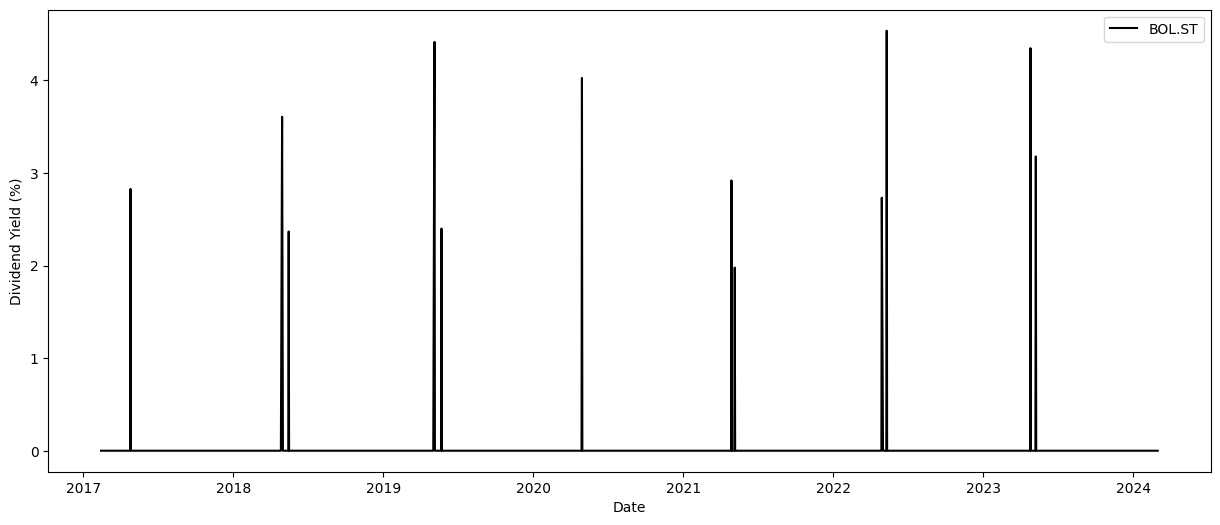

In [75]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.484682
share_price      1.000000
Name: share_price, dtype: float64


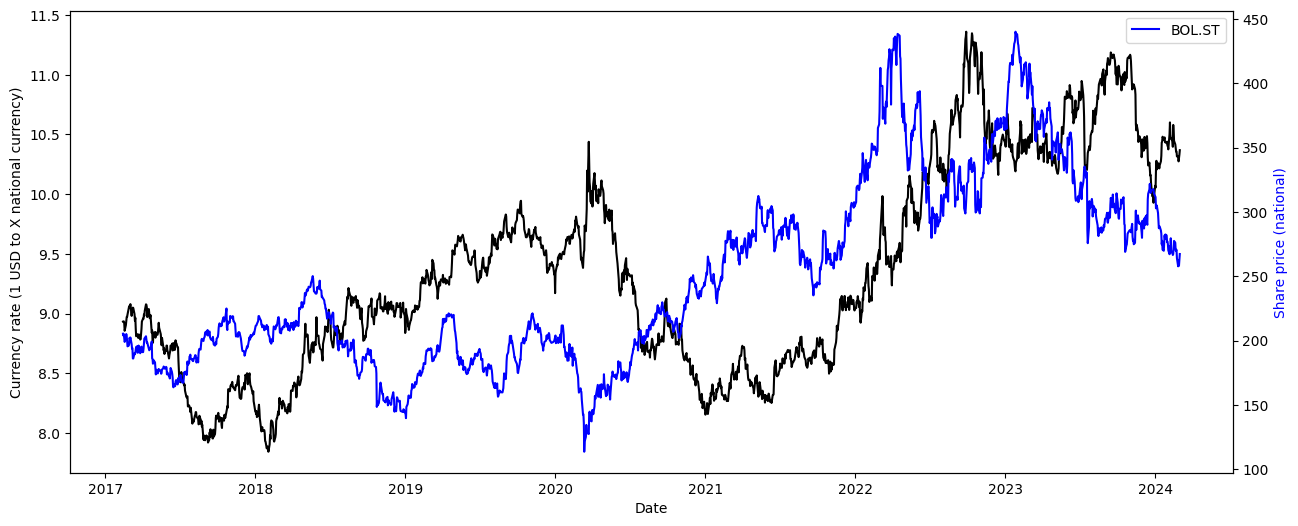

In [76]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

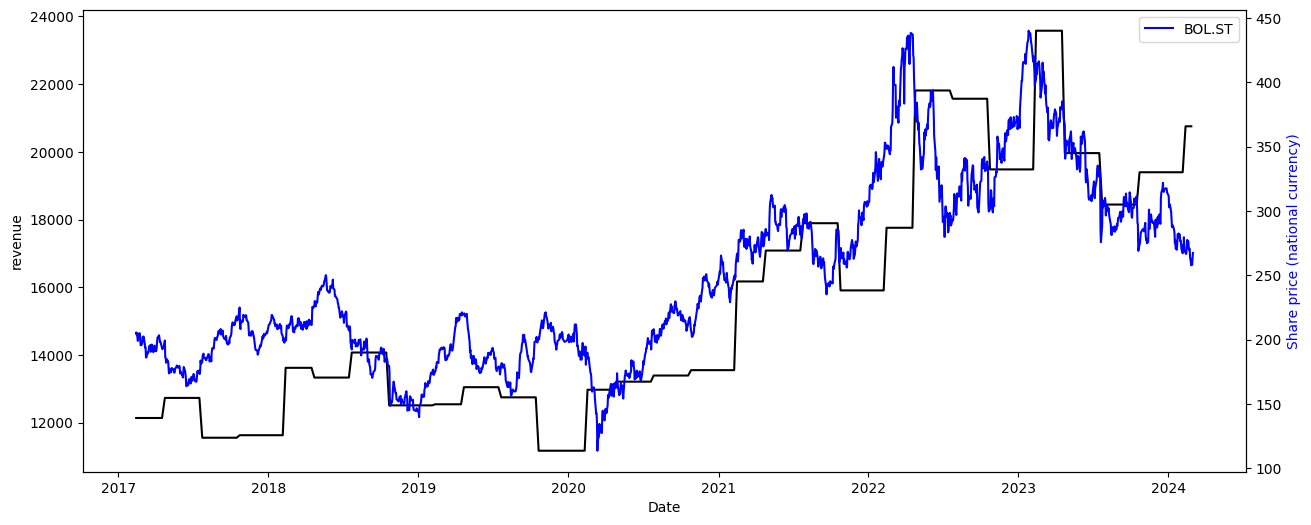

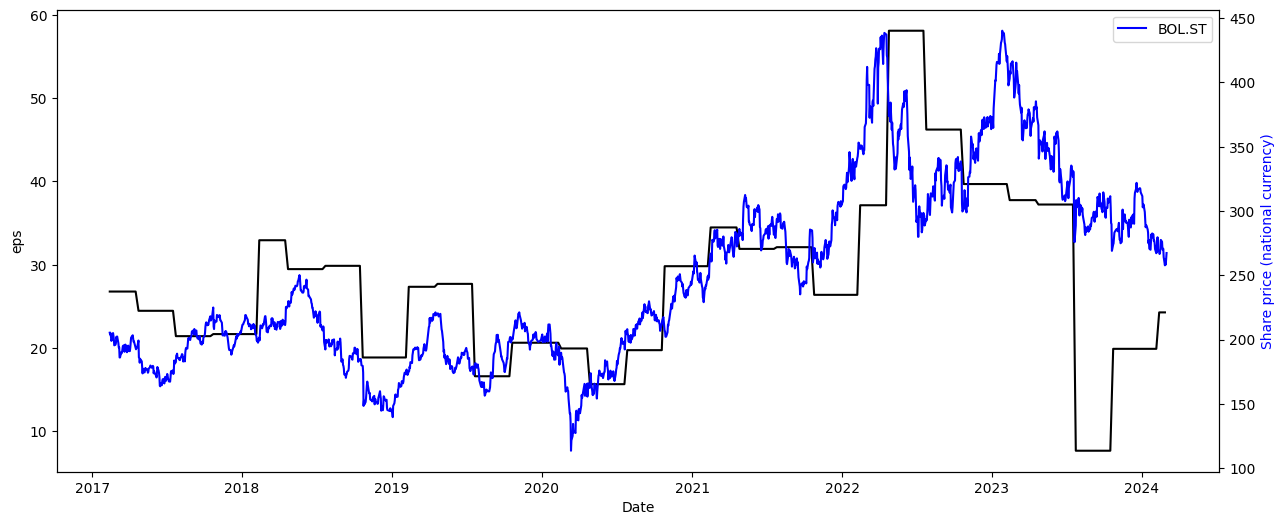

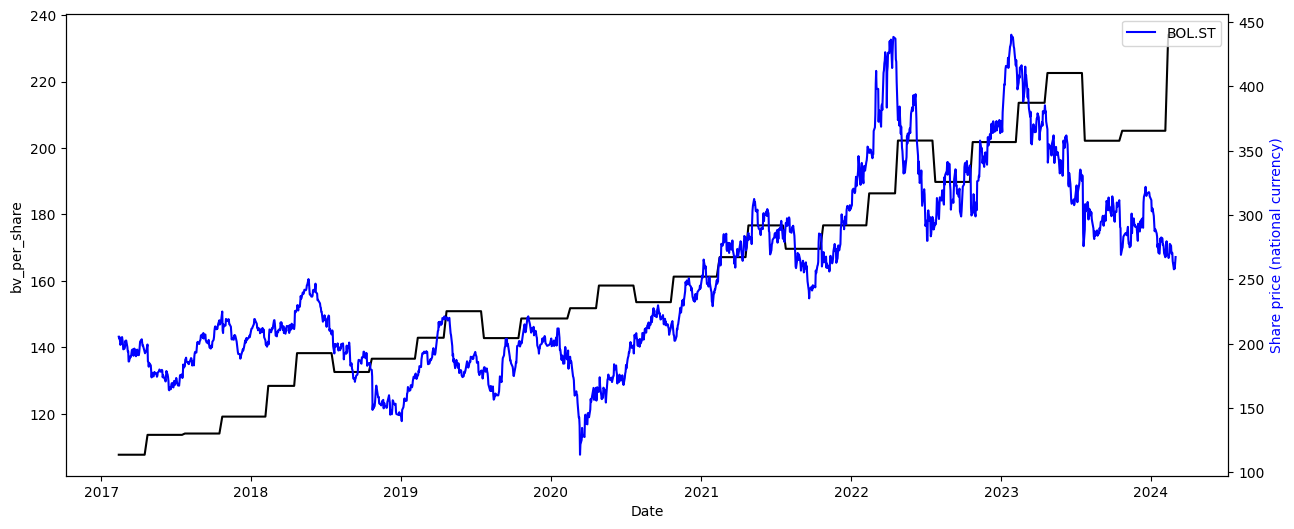

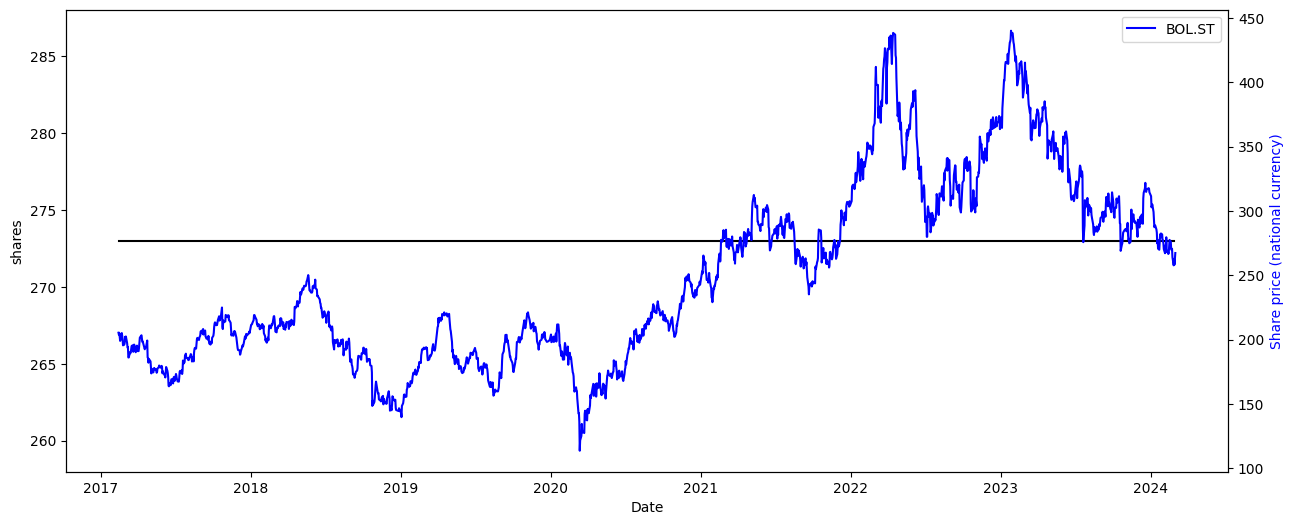

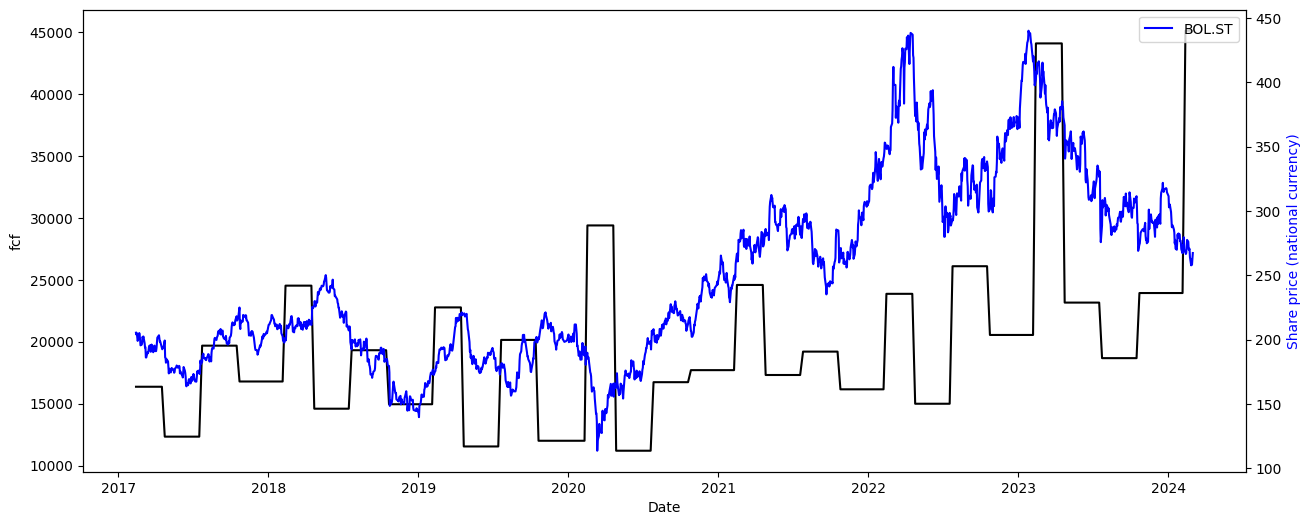

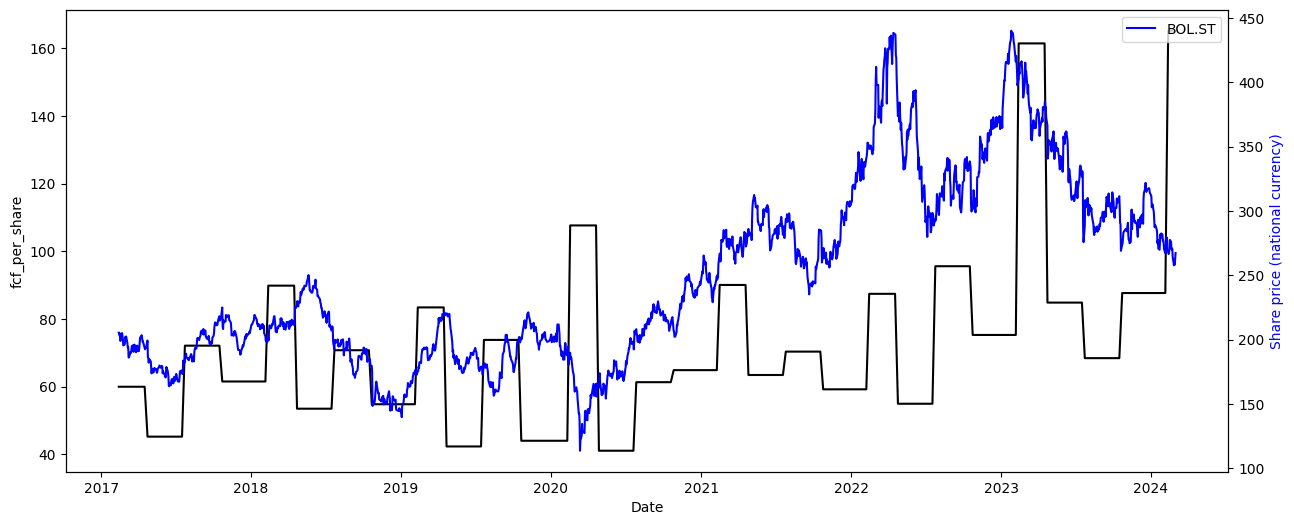

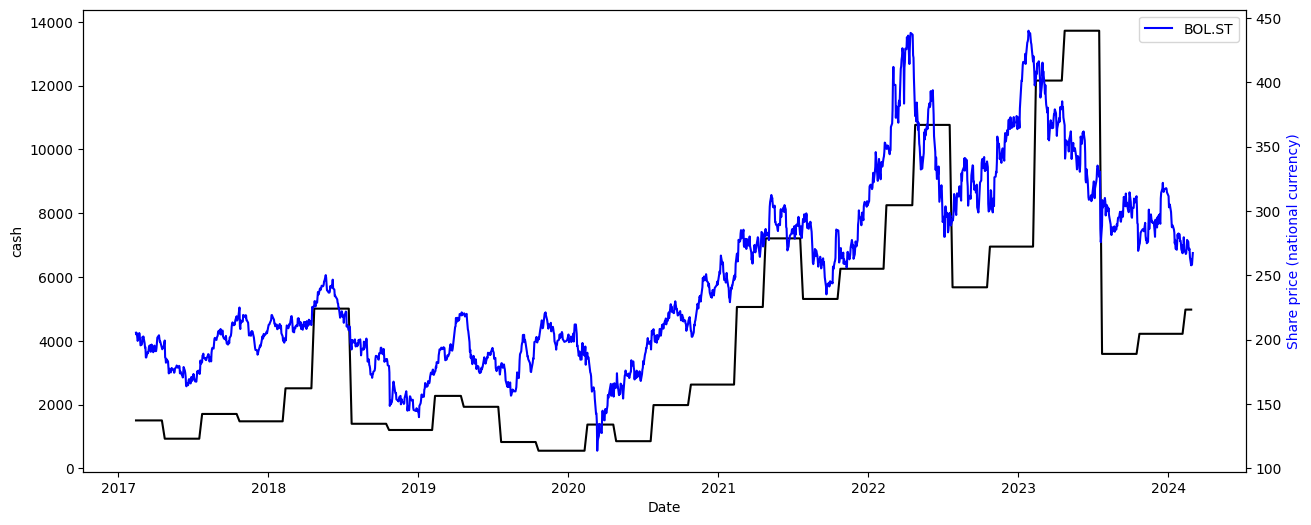

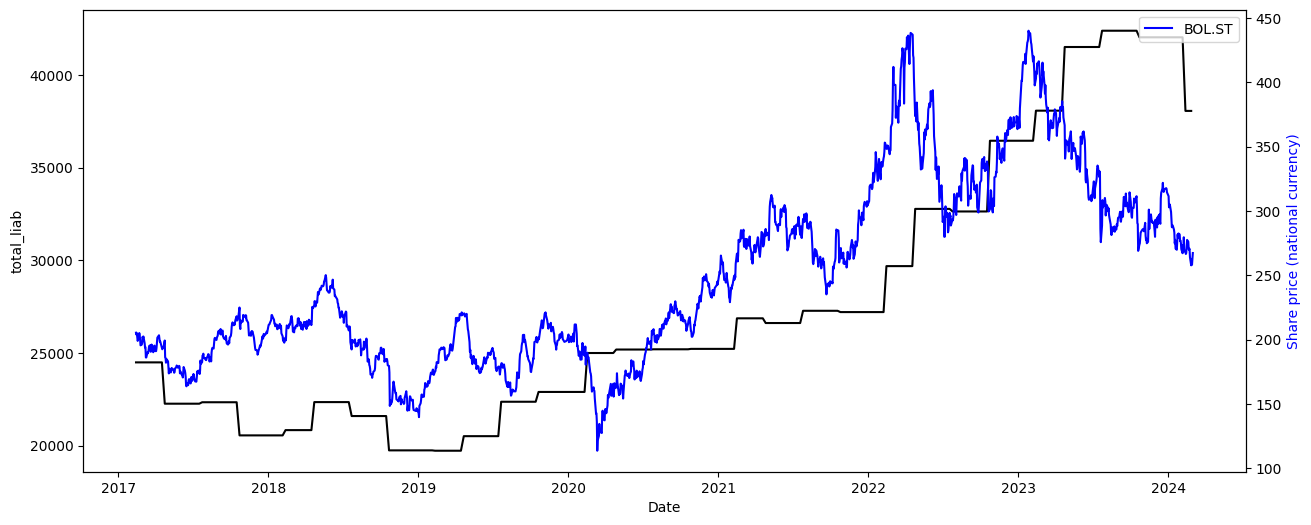

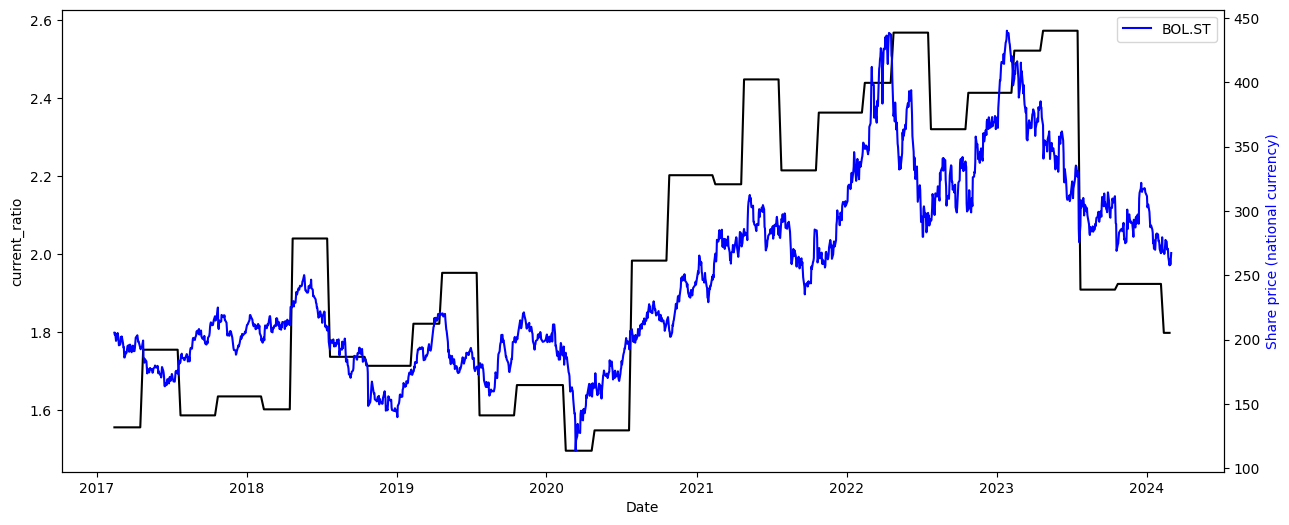

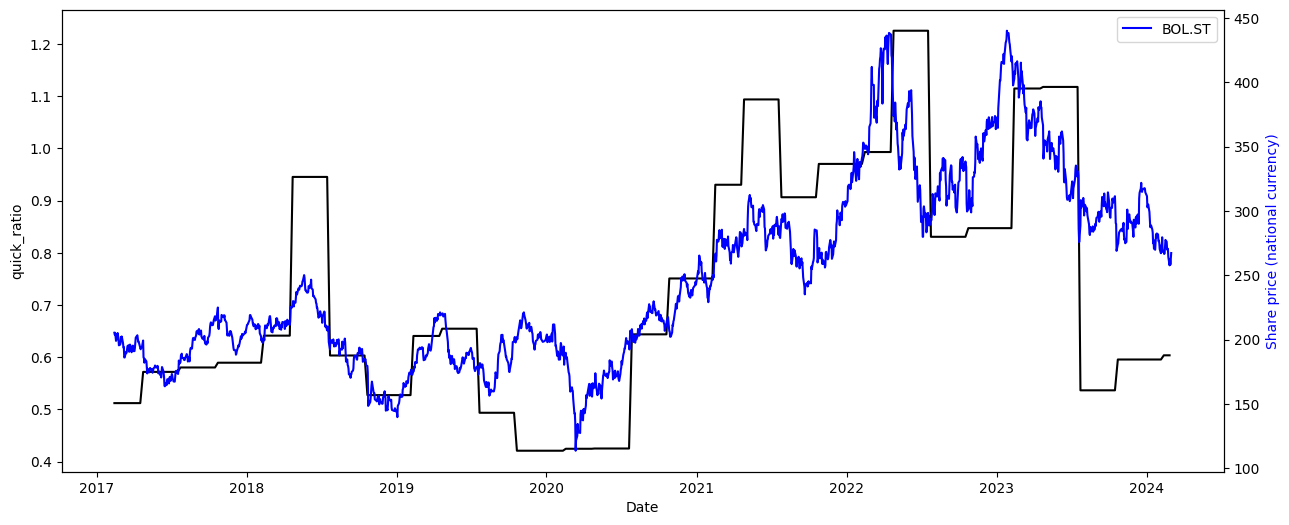

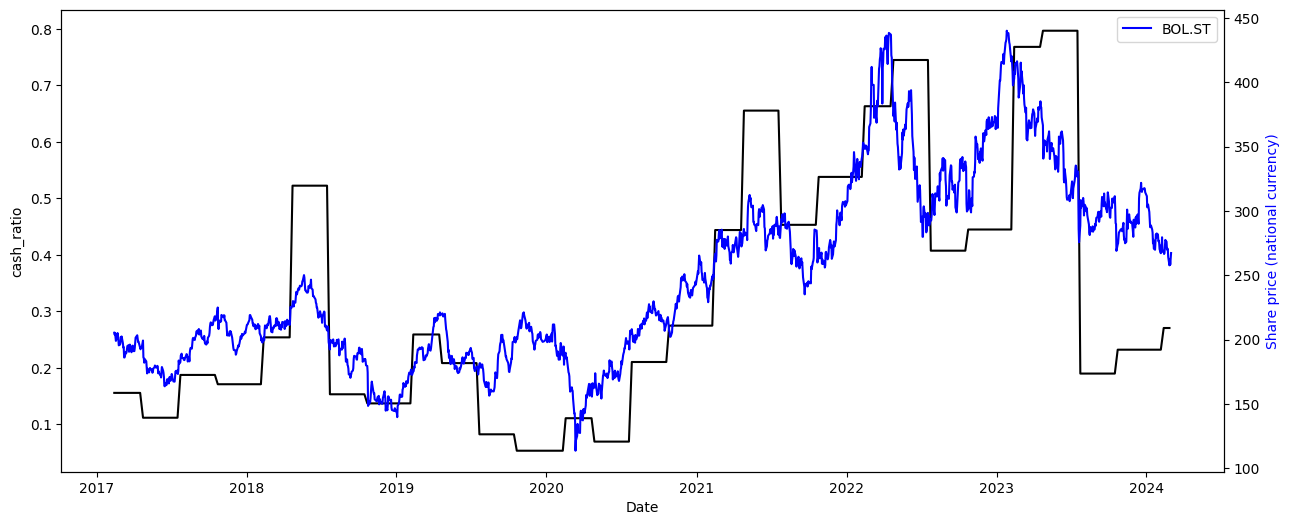

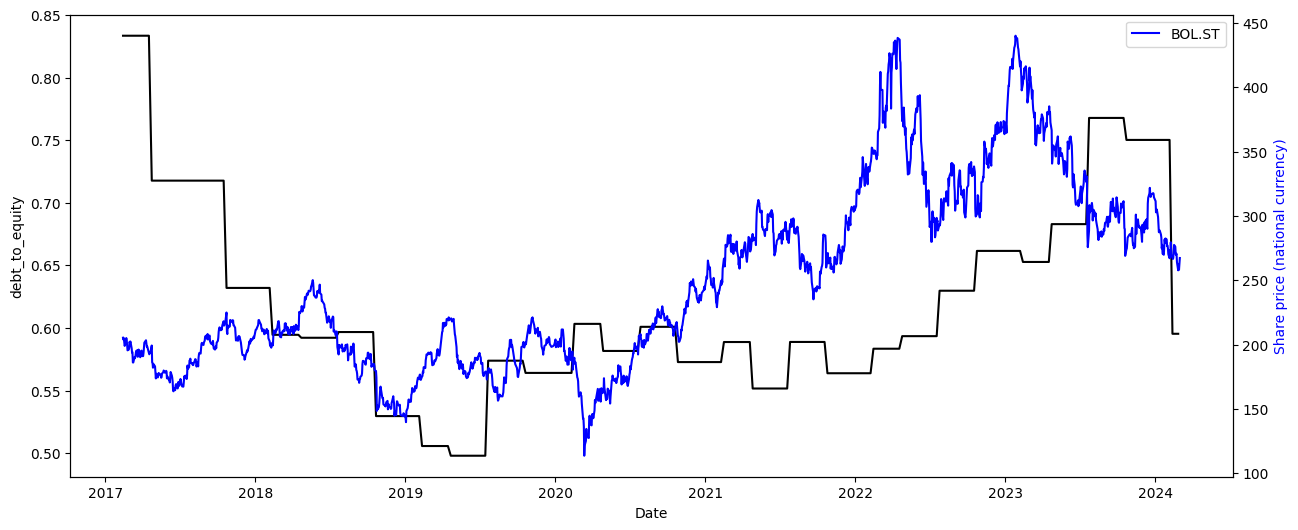

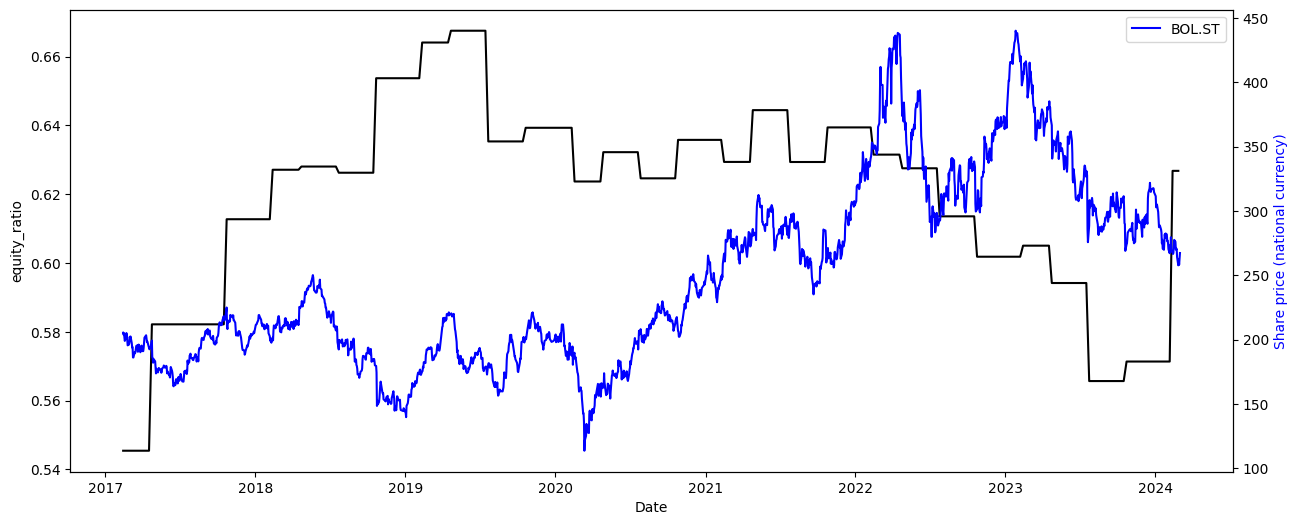

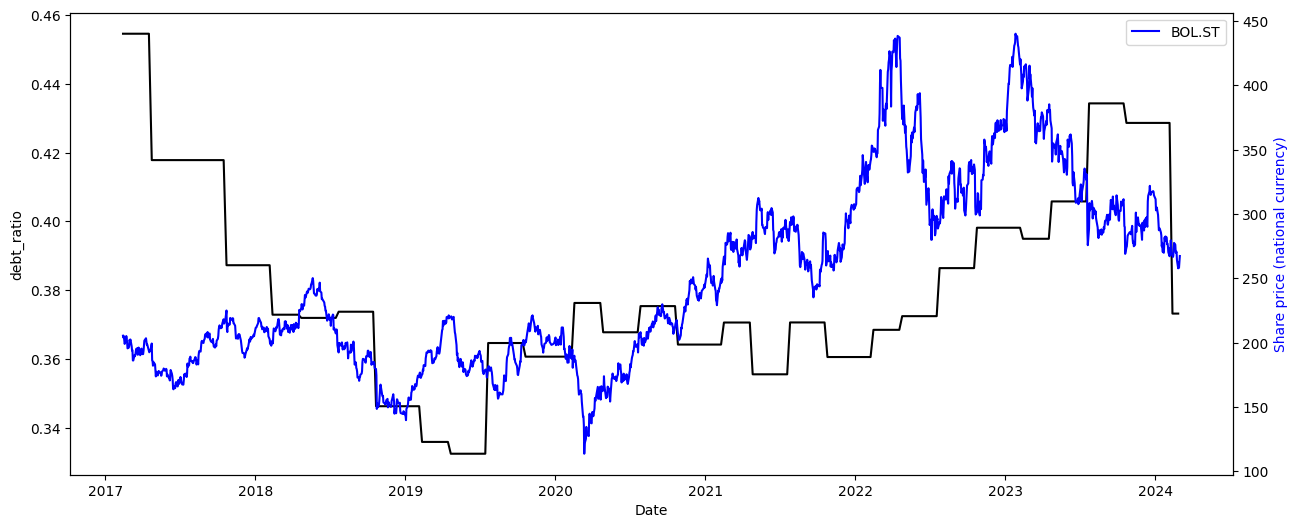

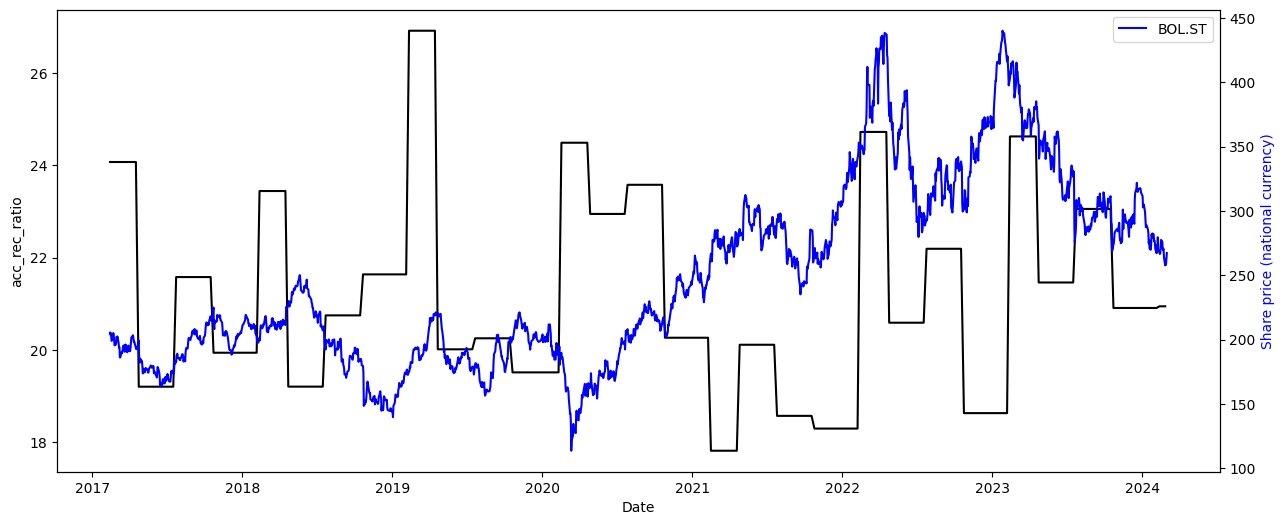

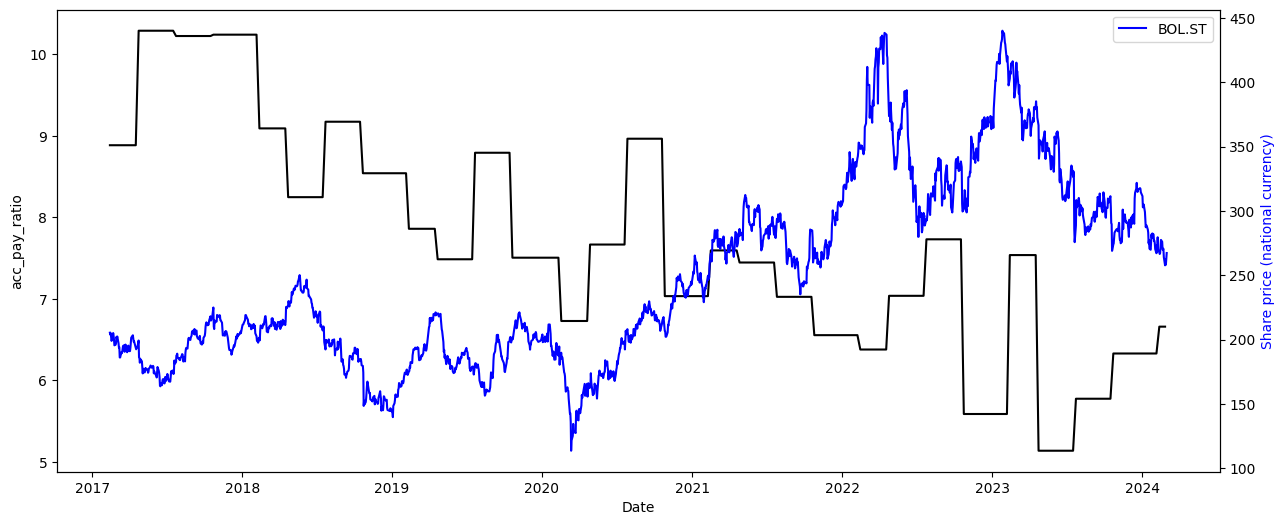

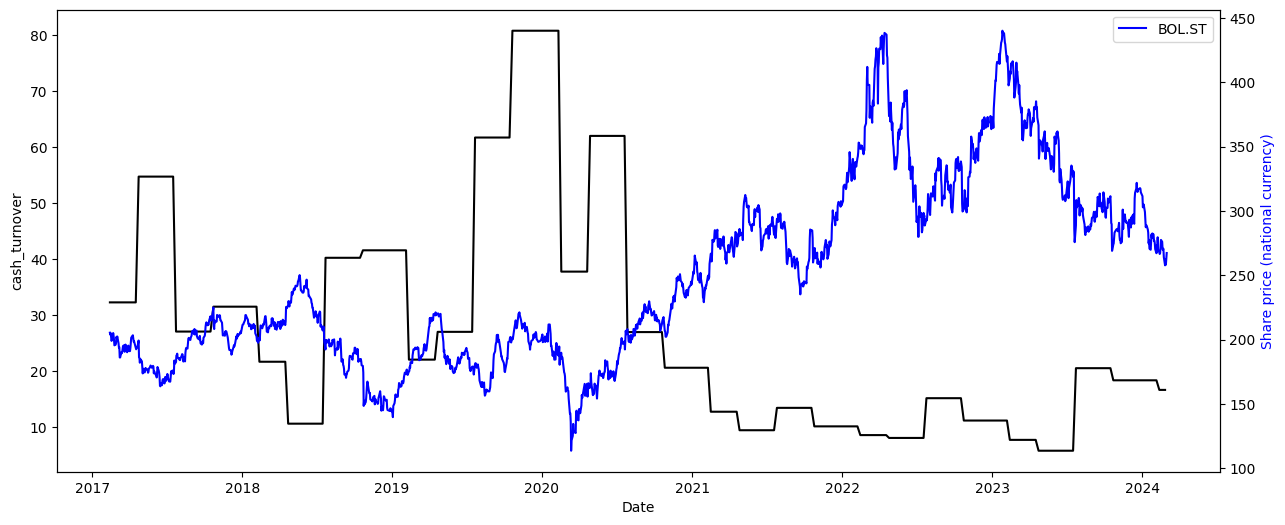

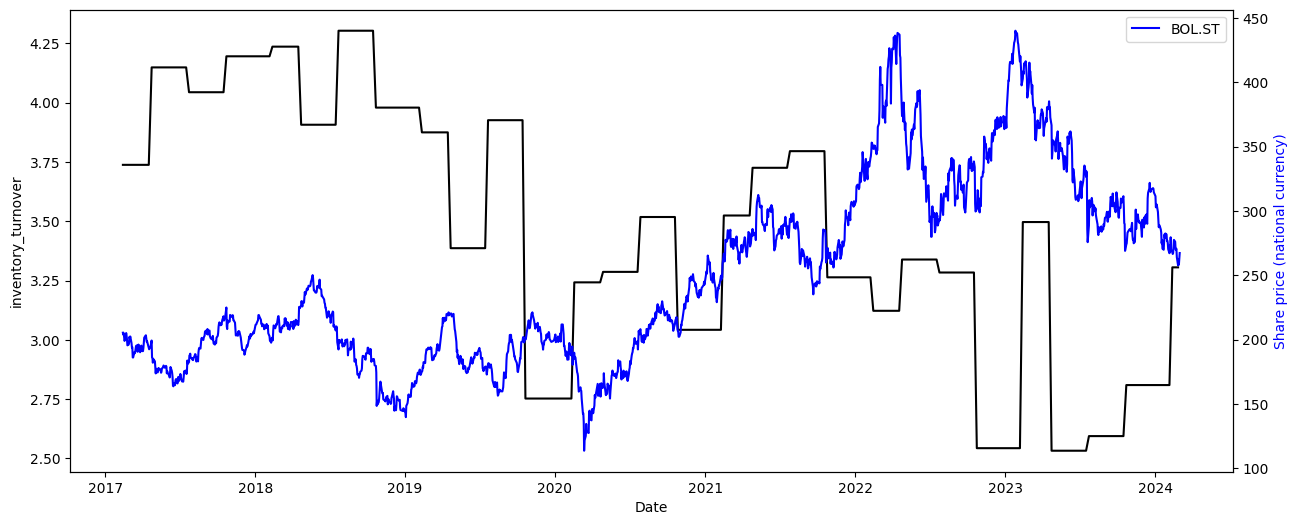

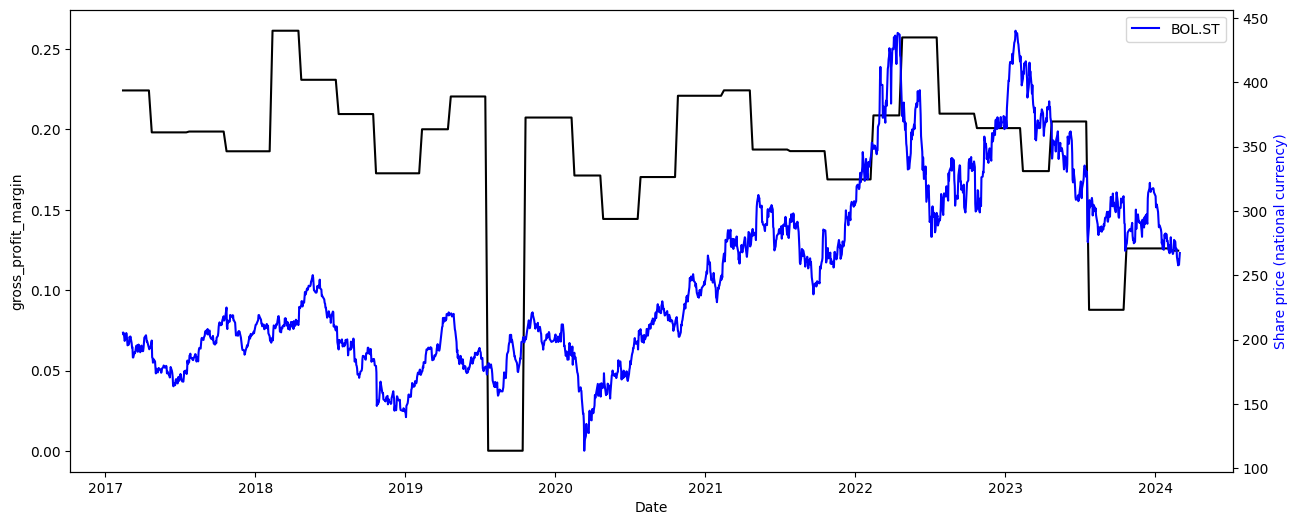

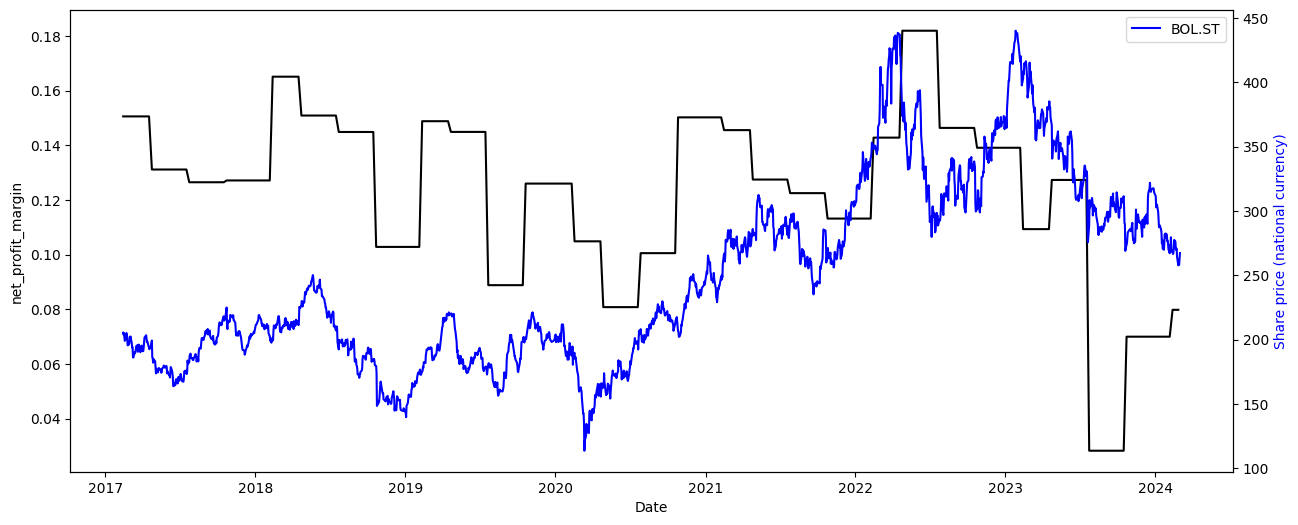

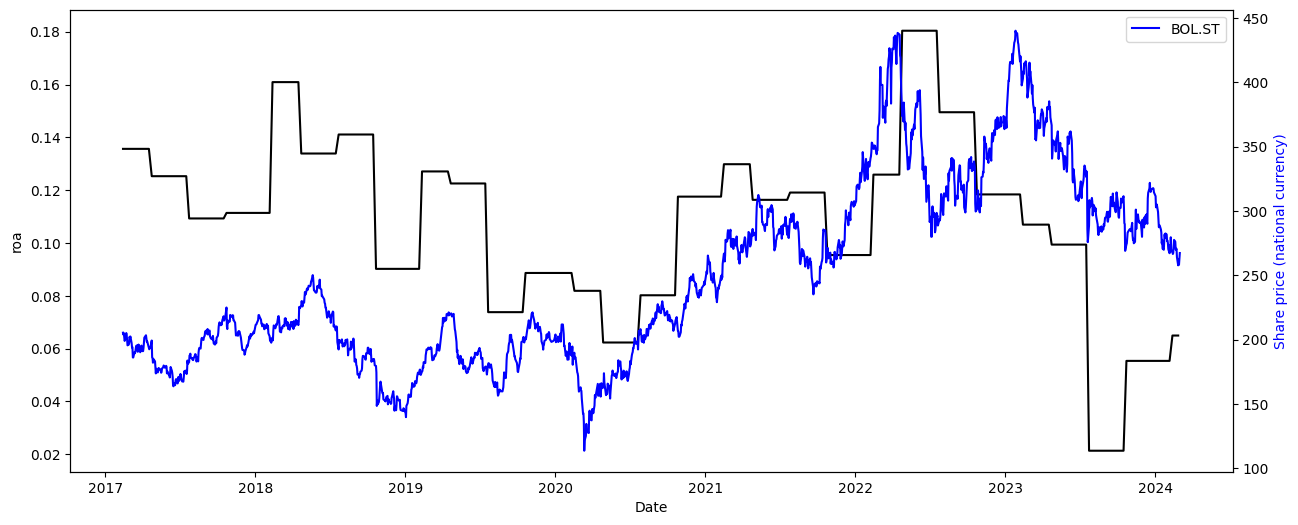

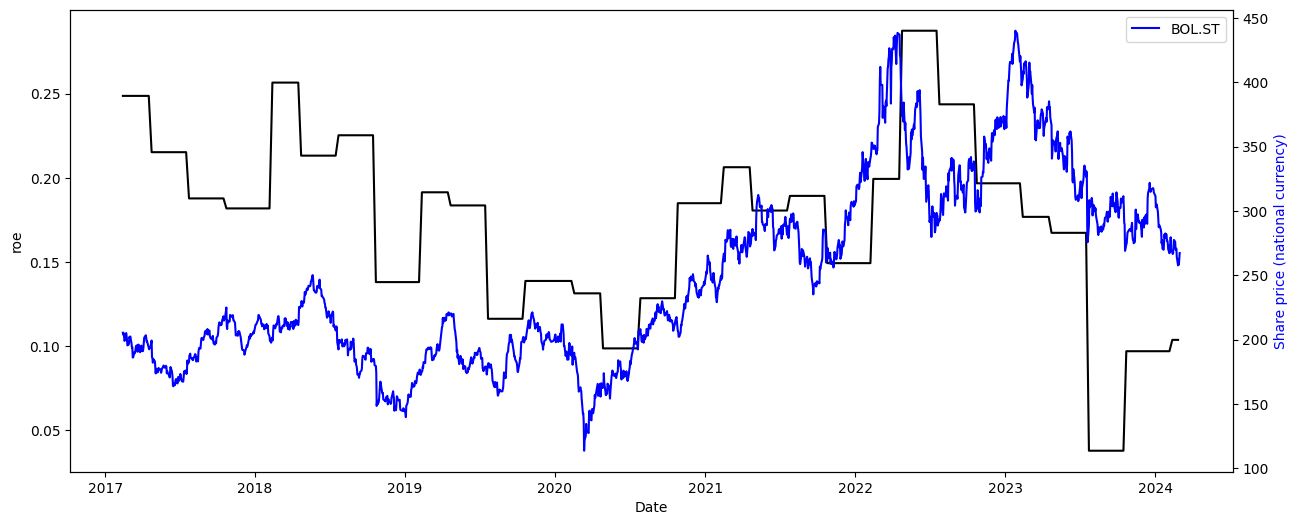

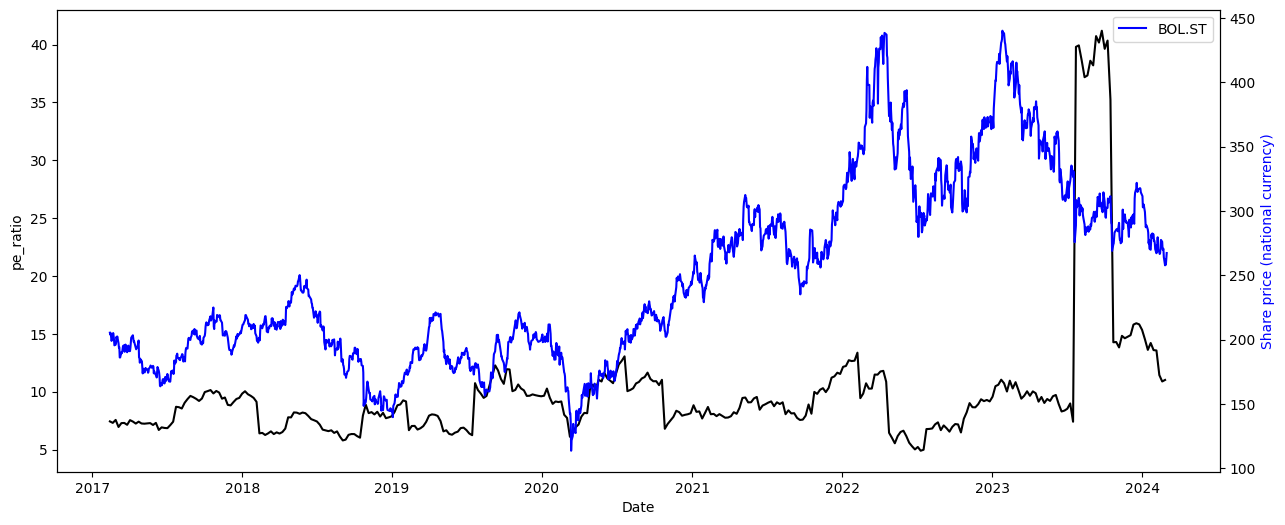

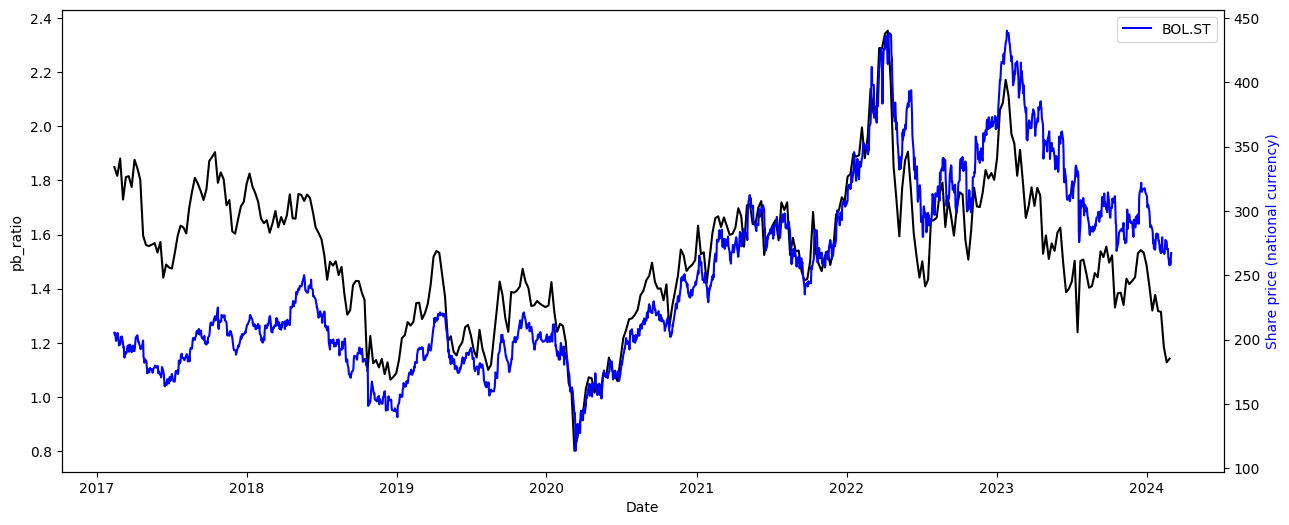

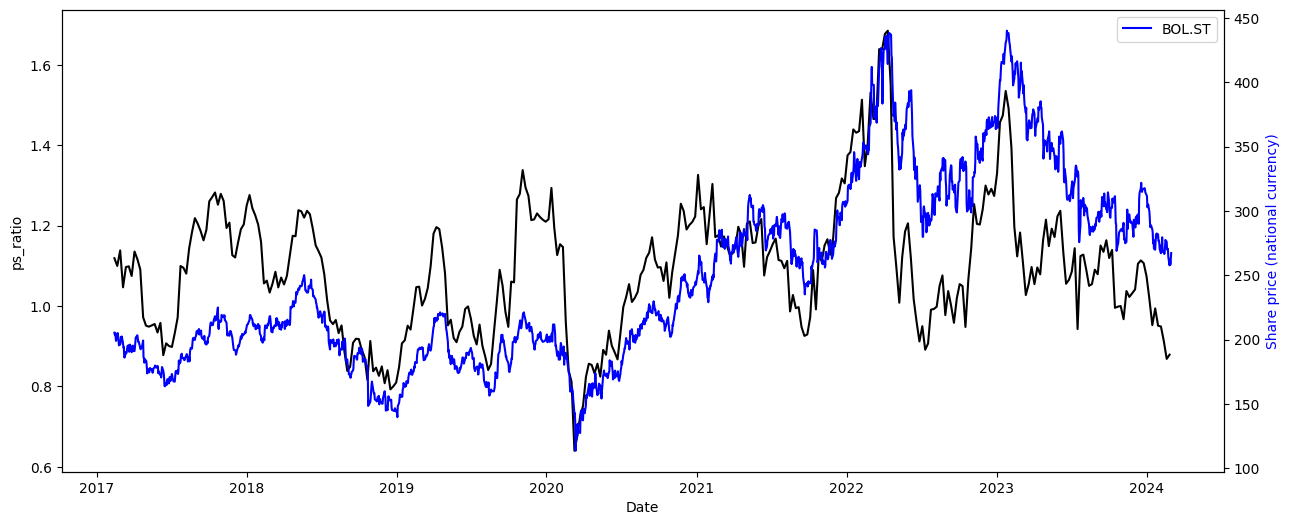

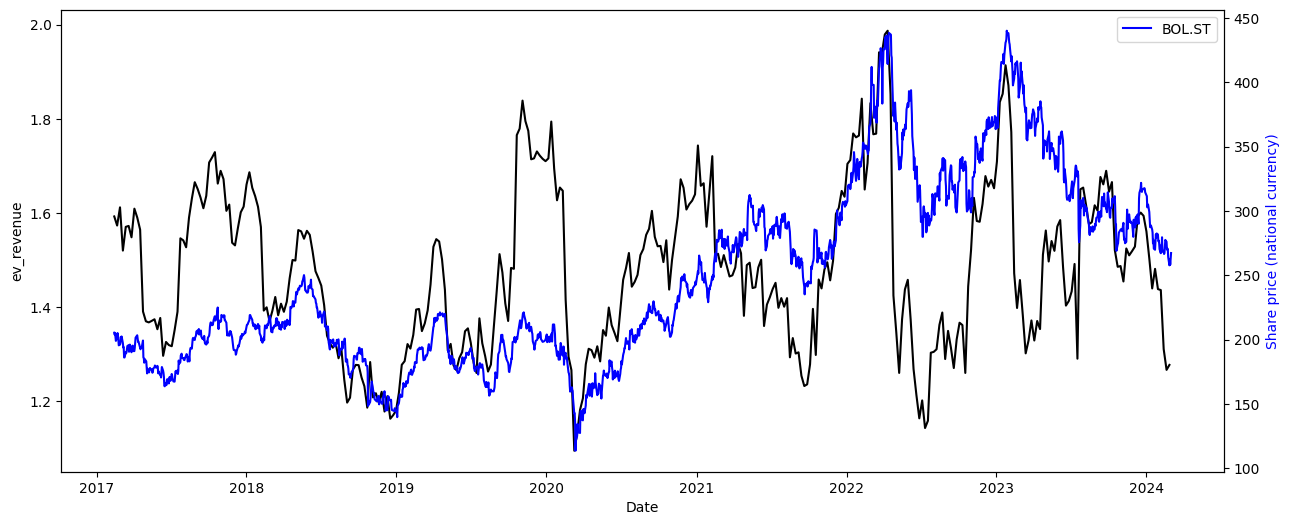

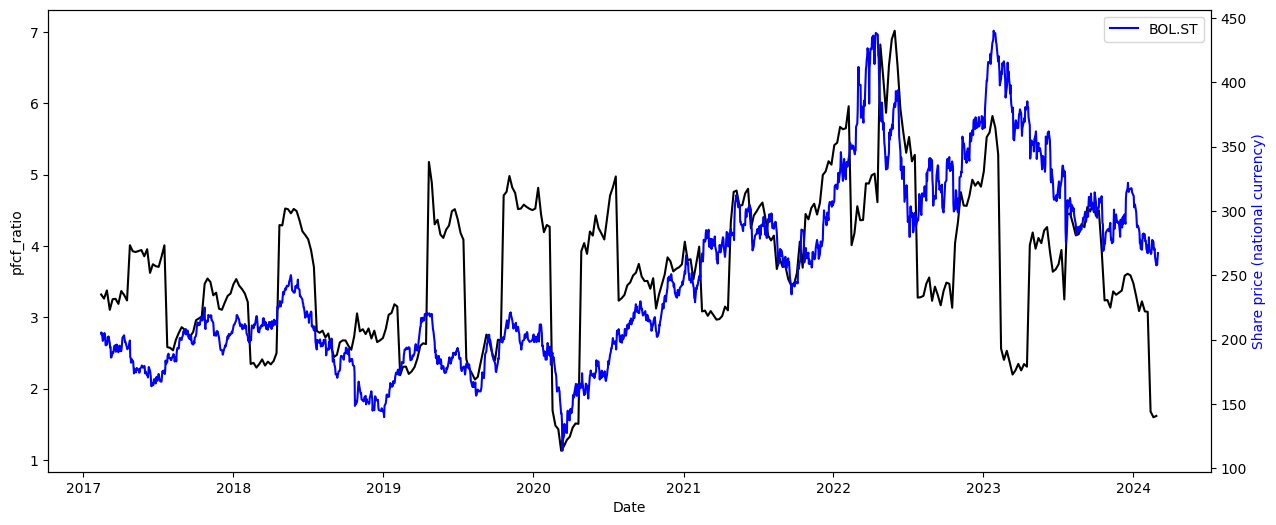

In [77]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

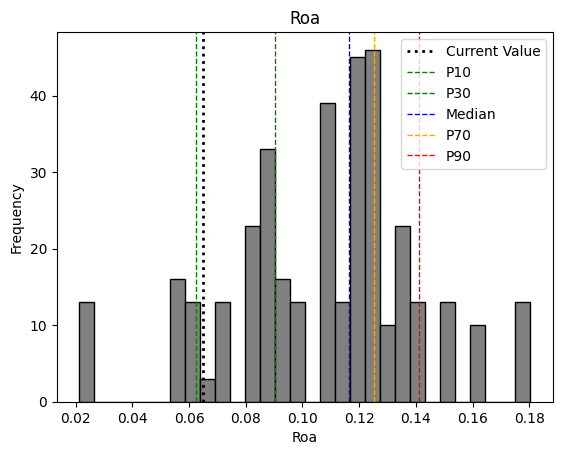

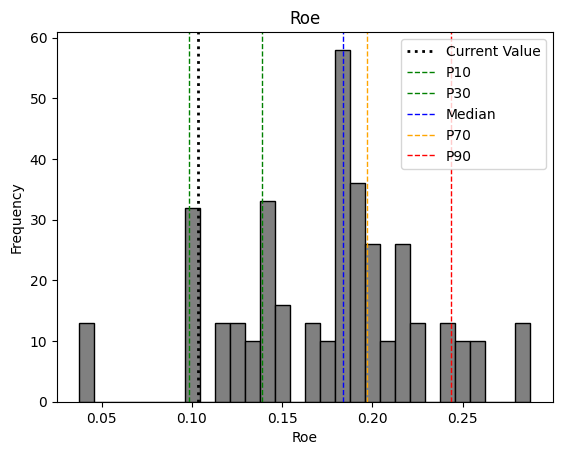

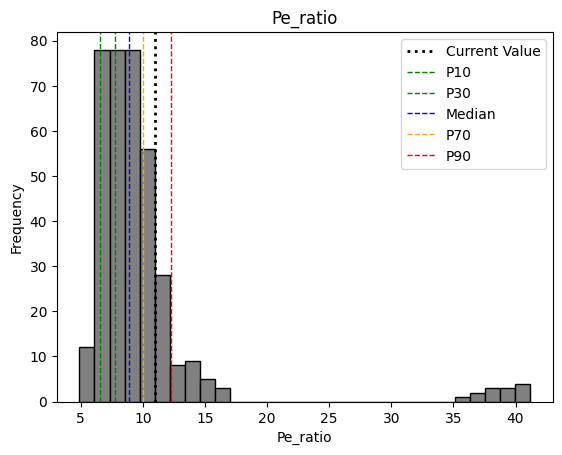

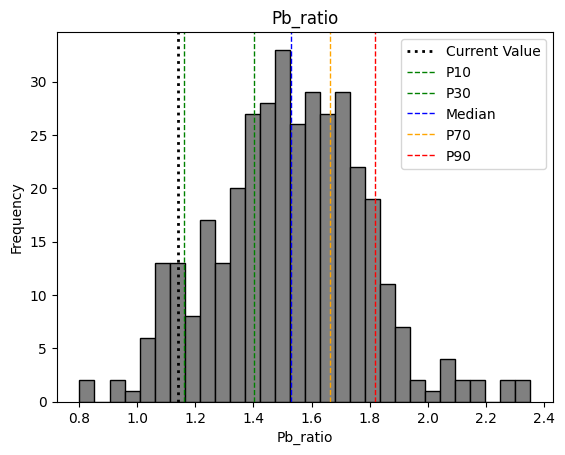

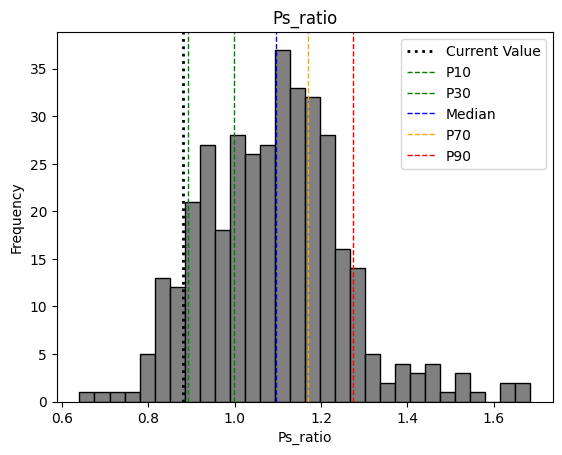

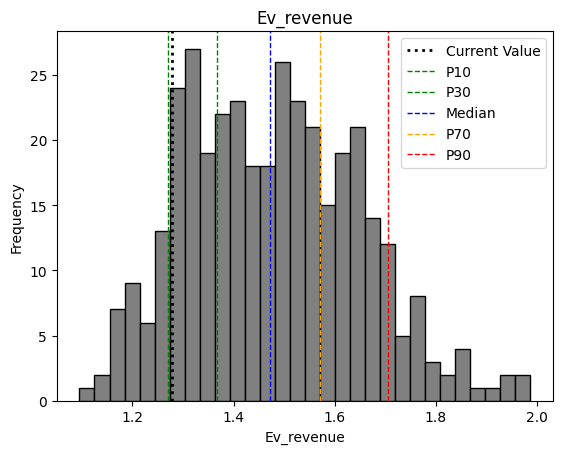

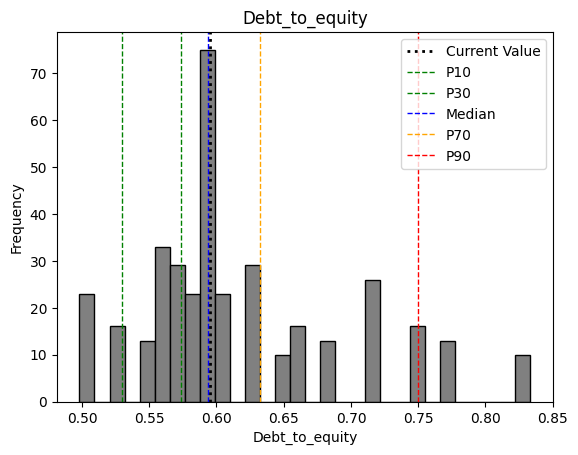

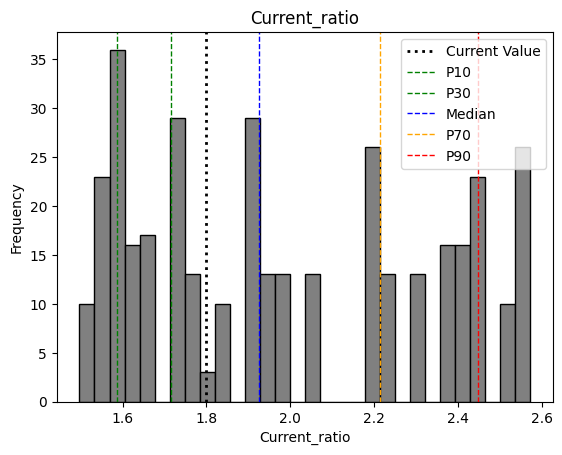

In [78]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [79]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.988660,-0.709157,0.436705,0.116785,-0.180226,-0.229149,0.305351
roe,0.988660,1.000000,-0.689030,0.485757,0.123236,-0.149606,-0.089454,0.283966
pe_ratio,-0.709157,-0.689030,1.000000,-0.008420,0.127299,0.324463,0.420550,-0.048655
pb_ratio,0.436705,0.485757,-0.008420,1.000000,0.802709,0.614047,0.301011,0.470775
ps_ratio,0.116785,0.123236,0.127299,0.802709,1.000000,0.909735,0.050140,0.413583
ev_revenue,-0.180226,-0.149606,0.324463,0.614047,0.909735,1.000000,0.238612,0.114165
debt_to_equity,-0.229149,-0.089454,0.420550,0.301011,0.050140,0.238612,1.000000,-0.088487
current_ratio,0.305351,0.283966,-0.048655,0.470775,0.413583,0.114165,-0.088487,1.000000


29 timestemos have been found!


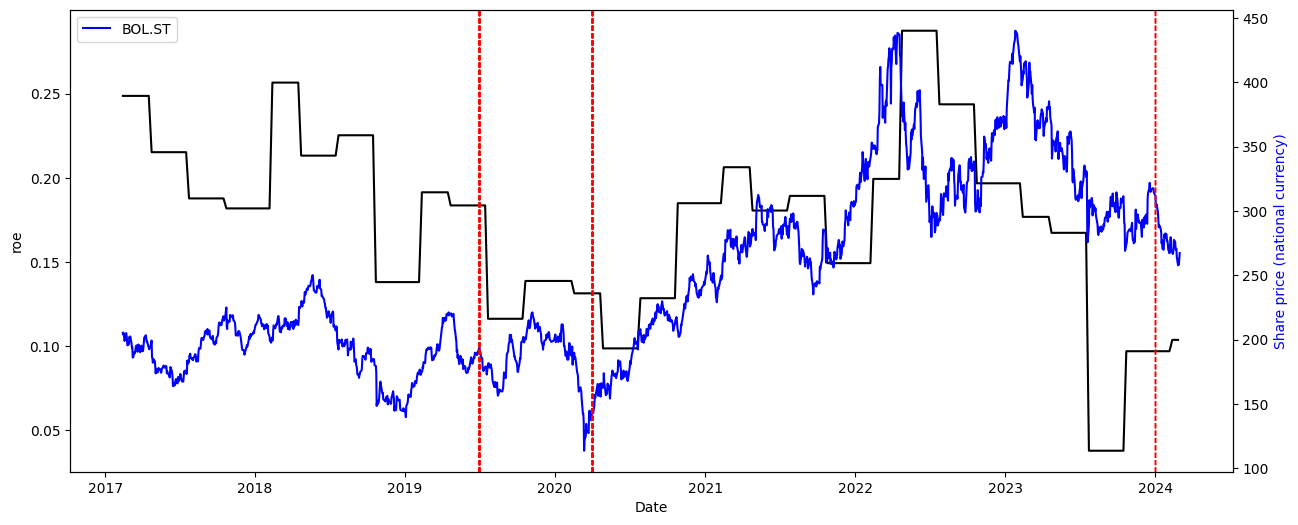

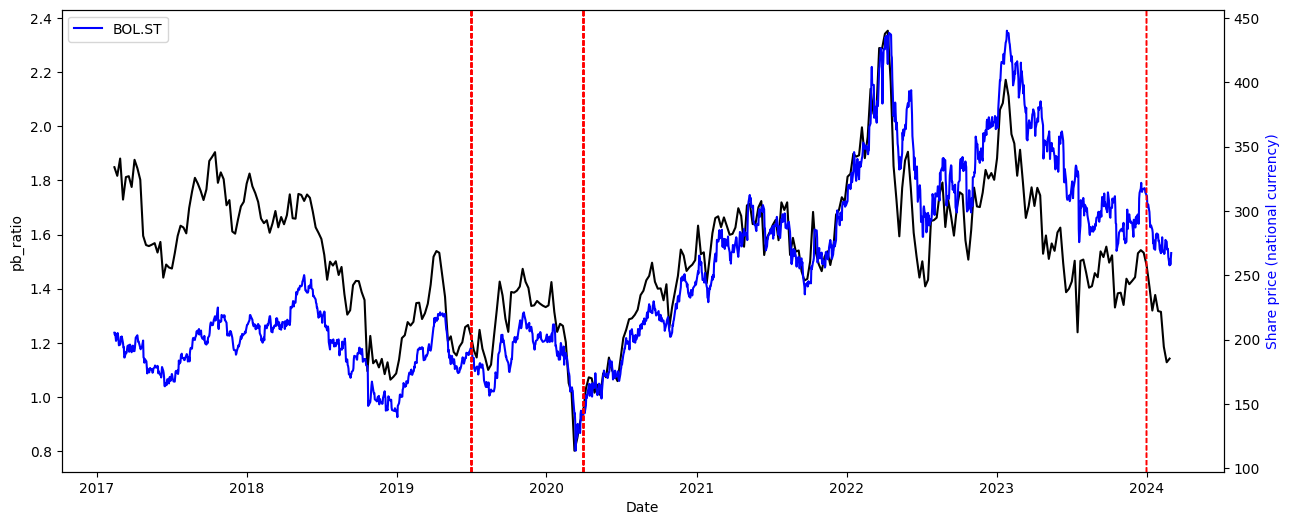

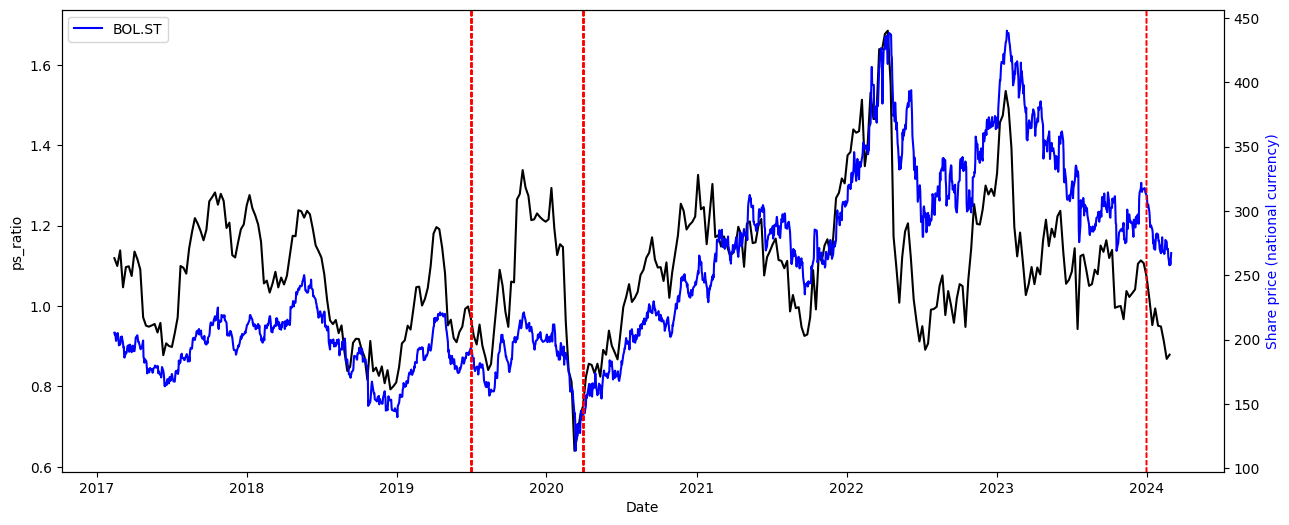

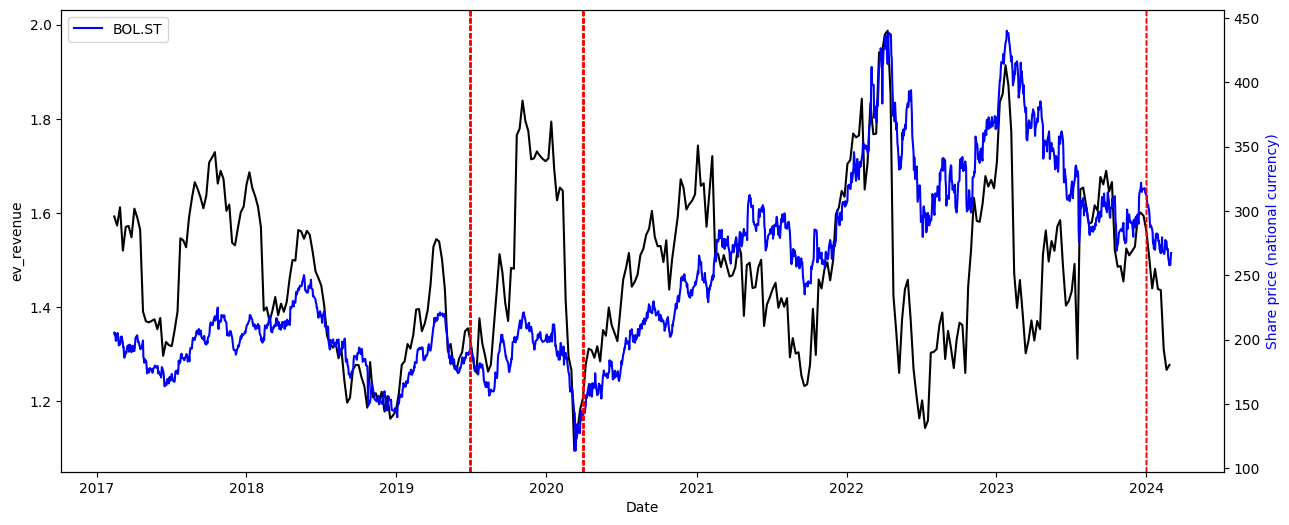

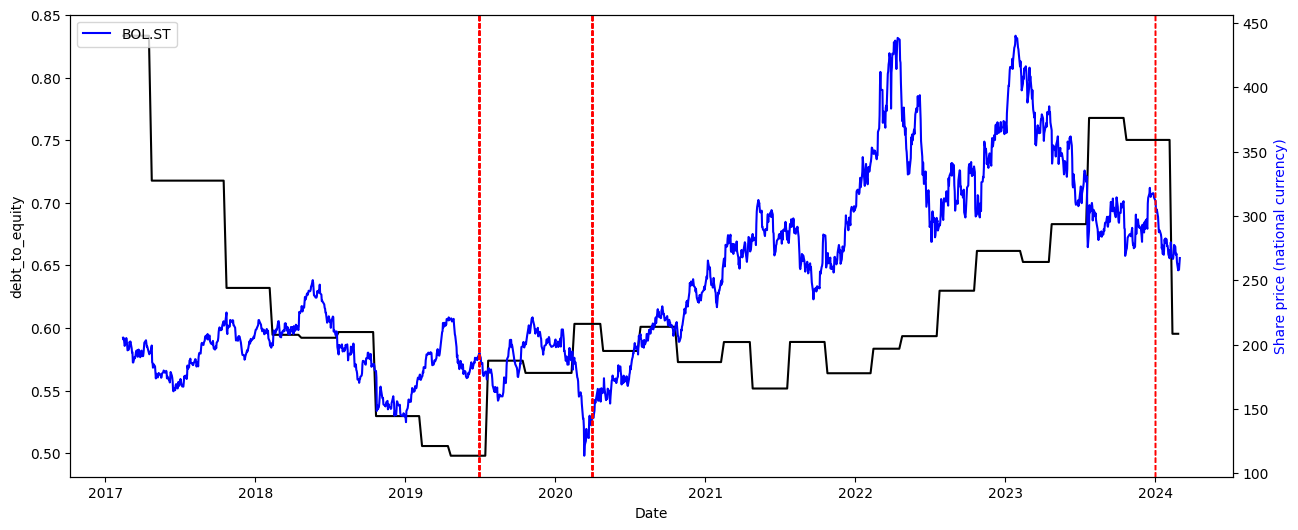

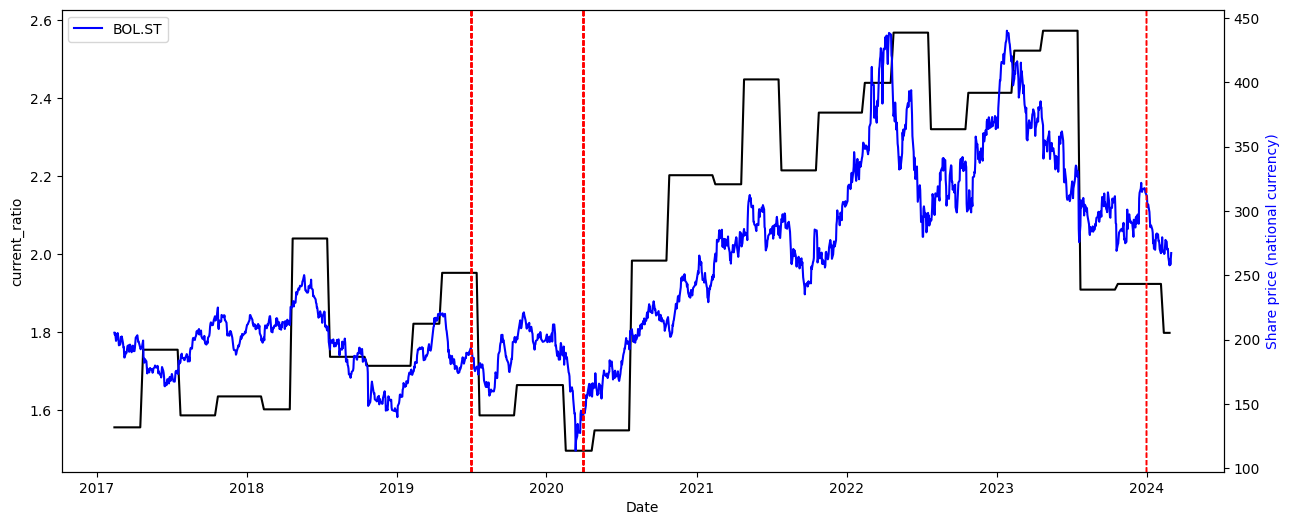

In [80]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )